In [1]:
import sys
sys.path.insert(0, '../..')
#for local import of parent dict

#Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms

from sklearn.metrics.pairwise import pairwise_distances
import scipy

import os
import numpy as np
import scanpy as sc
import pandas as pd

#synth Data
from ggml.generator import get_pointcloud, create_t_triplets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Optimal Transport
import ot

#Plotting
from ggml.plot import plot_distribution, plot_emb, hier_clustering, plot_ellipses
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline


3.4416913763379853e-15


/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_folder = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/"
'''
#Breastcancer
disease = "breastcancer"
dataset_name = "b8b5be07-061b-4390-af0a-f9ced877a068.h5ad"
label_col="reported_diseases"
patient_col="donor_id"


#Kidney
disease = "kidney"
dataset_name = "1c360b0b-eb2f-45a3-aba9-056026b39fa5.h5ad" #"5ccb0043-bb6f-4f00-b7e1-526d2726de9d.h5ad"
label_col="disease"
patient_col="donor_id"

'''
#Myocardial infarction
dataset_name = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
disease = "myocard_infarct"
#Myocard on major disease type and patients
#label_col="patient_group"  #Fib,Iz,Myo
#patient_col="donor_id"
#Myocard on specific samples and specific tissue zones
patient_col="sample"
label_col="major_labl"  #BZ,CTRL,FZ,IZ,RZ
'''
'''
n_threads = 100
n_cells = 500 #Cause normal dataloader only works for identical sizes
pca = None
adata = None

def get_cells_by_patients(adata_path,patient_col="donor_id",label_col="reported_diseases",subsample_patient_ratio=0.25,n_feats=None,filter_genes=False,**kwargs):
    global adata
    adata = sc.read_h5ad(adata_path)

    string_class_labels = np.unique(adata.obs[label_col])

    #detect low variable genes
    if filter_genes:
        gene_var = np.var(adata.X.toarray(),axis=0)

        #filter
        thresh = np.mean(gene_var) #TODO make this not hardcoded and arbitrary
        adata = adata[:,gene_var >thresh]


    distributions = []
    distributions_class = []
    patient_labels = []
    disease_labels = []
    celltype_node_label = []

    if n_feats is not None:
        global pca
        pca = PCA(n_components=n_feats, svd_solver='auto')
        pca.fit(adata.X)

    unique_patients = np.unique(adata.obs[patient_col])
    unique_patients_subsampled = np.random.choice(unique_patients, size = int(len(unique_patients)*subsample_patient_ratio),replace=False)


    for patient in unique_patients_subsampled:


        patient_adata = adata[adata.obs[patient_col] == patient]

        disease_label = np.unique(patient_adata.obs[label_col].to_numpy())
        string_class_label = disease_label[0]
        if len(disease_label) > 1:
            print("Warning, sample_ids refer to cells with multiple disease labels (likely caused by referencing by patients and having multiple samples from different zones)")

        '''
        #This is only relevant for datasets that contain multiple samples
        unique,pos = np.unique(patient_adata.obs[label_col].to_numpy(),return_inverse=True) #Finds all unique elements and their positions
        for sample in unique:


        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = counts.argmax()                      #Finds the positions of the maximum count
        string_class_label = unique[maxpos] #we take the label that occurs most often for this patient
        patient_adata = adata[adata.obs[label_col] == string_class_label ] # and only keep those (this is only relevant for myocardial infarction)
        '''

        if patient_adata.n_obs >= n_cells:
            

            sc.pp.subsample(patient_adata,n_obs = n_cells) 

            #if n_feats == 50:
            #    p_arr = np.asarray(patient_adata.obsm["X_pca"],dtype="f")
            #else:
            p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?
            if n_feats is not None:
                p_arr = pca.transform(p_arr)

            distributions.append(p_arr)
            
            disease_labels.append(string_class_label)
            distributions_class.append(np.where(string_class_labels==string_class_label)[0][0])
            patient_labels.append(patient)
            celltype_node_label.append(list(patient_adata.obs['cell_type']))
            

    

    return distributions, distributions_class, patient_labels, disease_labels, celltype_node_label

#distributions, distributions_labels, patient_labels = get_cells_by_patients(dataset_folder+dataset_name,patient_col="donor_id",label_col=label_col)
#print(distributions_labels)

def pairwise_mahalanobis_distance_npy(X_i,X_j,w=None):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if w is None:
        w = np.identity(X_i.shape[-1])
    else:
        w = w.astype("f")

    X_i = X_i.astype("f")
    X_j = X_j.astype("f")

    #Transform poins of X_i,X_j according to W
    if w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        #w = np.diag(w)
        #proj_X_i = np.matmul(X_i,w)
        #proj_X_j = np.matmul(X_j,w)

        proj_X_i = X_i * w[None,:]
        proj_X_j = X_j * w[None,:]

    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  

In [3]:
class scRNA_Dataset(Dataset):
    #The __init__ function is run once when instantiating the Dataset object.
    def __init__(self, *args, **kwargs):
        #Generate syntehtic data
        distributions, distributions_labels, patient_labels, disease_labels, celltype_node_labels = get_cells_by_patients(*args, **kwargs)
        
        #Population-level 
        self.distributions = distributions
        self.distributions_labels = distributions_labels
        self.disease_labels = disease_labels
        self.patient_labels = patient_labels

        #Unit-level  TODO
        #self.datapoints = points 
        #self.datapoints_labels = point_labels
        self.celltype_node_labels = celltype_node_labels 

        #Triplets
        self.triplets = create_t_triplets(distributions,distributions_labels,**kwargs) #TODO neighbors as param

    def __len__(self):
        #Datapoints to train are always given as triplets
        return len(self.triplets)

    def __getitem__(self, idx):
        #Returns elements and labels of triplet at idx
        i,j,k = self.triplets[idx]
        return np.stack((self.distributions[i],self.distributions[j],self.distributions[k])),np.stack((self.distributions_labels[i],self.distributions_labels[j],self.distributions_labels[k]))
    
    def compute_OT_on_dists(self,ground_metric = None,w = None,symbols=None):
        D = np.zeros((len(self.distributions),len(self.distributions)))
        for i,distribution_i in enumerate(tqdm(self.distributions)):
            for j,distribution_j in enumerate(self.distributions):
                if i < j:
                    if w is not None:
                        M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)
                    else:
                        M = sp.spatial.distance.cdist(distribution_i,distribution_j)
                    D[i,j] = ot.emd2([],[],M,numThreads=n_threads)
                else:
                    D[i,j]=D[j,i]
        
        plot_emb(D,method='umap',colors=self.disease_labels,symbols=symbols,legend="Side",title="UMAP",verbose=True,annotation=None,s=200)
        plot_emb(D,method='phate',colors=self.disease_labels,symbols=symbols,legend="Side",title="Phate",verbose=True,annotation=None,s=200)

        hier_clustering(D,self.disease_labels, ax=None,dist_name="W_θ")
        return D

In [4]:
pca_c = None
n_threads = 32
n_cells = 1000 
subsample_patient_ratio=0.6

neighbor_t = [3] 
rank_k = [5]

alphas = [1] 
lambdas = [10] 


training_data = {}
train_dataset = {}

for a in alphas:
    for l in lambdas:
        for t in neighbor_t:
                for k in rank_k:
                        training_data[(a,l,t,k)] = scRNA_Dataset(dataset_folder+dataset_name,patient_col=patient_col,label_col=label_col,n_feats=pca_c,filter_genes=True,t=t,subsample_patient_ratio=subsample_patient_ratio)
                #test_data = CustomSyntheticDataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False)

                        train_dataset[(a,l,t,k)] = DataLoader(training_data[(a,l,t,k)], batch_size=128, shuffle=True)
#test_dataset = DataLoader(test_data, batch_size=64, shuffle=True)

#PLOTTING
'''
feat_dim = next(iter(train_dataset))[0].shape[-1]

w = np.ones((feat_dim))
training_data.compute_OT_on_dists(w = w,legend=None)

w = np.zeros((feat_dim))
w[0] = 1
training_data.compute_OT_on_dists(w = w,legend=None) #euclidean
'''



passed neighs: 3


'\nfeat_dim = next(iter(train_dataset))[0].shape[-1]\n\nw = np.ones((feat_dim))\ntraining_data.compute_OT_on_dists(w = w,legend=None)\n\nw = np.zeros((feat_dim))\nw[0] = 1\ntraining_data.compute_OT_on_dists(w = w,legend=None) #euclidean\n'

In [5]:
'''
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


trpl_distributions = train_features[0]
trpl_label = train_labels[0]


plot_distribution(trpl_distributions,trpl_label)

plt.show()
print(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")
'''

'\ntrain_features, train_labels = next(iter(train_dataset))\nprint(f"Feature batch shape: {train_features.size()}")\nprint(f"Labels batch shape: {train_labels.size()}")\n\n\ntrpl_distributions = train_features[0]\ntrpl_label = train_labels[0]\n\n\nplot_distribution(trpl_distributions,trpl_label)\n\nplt.show()\nprint(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")\n'

In [6]:
def pairwise_mahalanobis_distance(X_i,X_j,w):
    # W has shape (rank k<=dim) x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 


    #Transform poins of X_i,X_j according to W
    if w.dim() == 1:
        #assume cov=0, scale dims by diagonal
        proj_X_i = X_i * w[None,:]
        proj_X_j = X_j * w[None,:]

    else: 
        w = torch.transpose(w,0,1)
        proj_X_i = torch.matmul(X_i,w)
        proj_X_j = torch.matmul(X_j,w)

    return torch.linalg.norm(proj_X_i[:,torch.newaxis,:]  -  proj_X_j[torch.newaxis,:,:],dim=-1)    

#The next row is just to get the feature dimensions from a dict of dataloaders (which we need to start iterating over to get an example datapoint)
dim = next(iter(list(train_dataset.values())[0]))[0].shape[-1] 
dia_only = False


'''
w_euc = torch.from_numpy(np.asarray([[1,0],[0,1]],dtype="f"))


w_opt = torch.from_numpy(np.asarray([[1,0],[0,0]],dtype="f"))
w_opt.requires_grad_(requires_grad=True) 


x = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))
y = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))
z = torch.from_numpy(np.asarray([[0,0],[0,1],[0,0],[0,1]],dtype="f"))

print(pairwise_mahalanobis_distance(x,y,w_rand))
print(pairwise_mahalanobis_distance(x,y,w_opt))
'''


'\nw_euc = torch.from_numpy(np.asarray([[1,0],[0,1]],dtype="f"))\n\n\nw_opt = torch.from_numpy(np.asarray([[1,0],[0,0]],dtype="f"))\nw_opt.requires_grad_(requires_grad=True) \n\n\nx = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))\ny = torch.from_numpy(np.asarray([[1,0],[1,1],[1,0],[0,1]],dtype="f"))\nz = torch.from_numpy(np.asarray([[0,0],[0,1],[0,0],[0,1]],dtype="f"))\n\nprint(pairwise_mahalanobis_distance(x,y,w_rand))\nprint(pairwise_mahalanobis_distance(x,y,w_opt))\n'

In [7]:
from tqdm import tqdm

lr = 0.01


n_threads = 100
iterations= 50 #0
plot_every_i_iterations = 20
save_every_i_iterations = 5


def triplet_loss(triplet,w,alpha=torch.scalar_tensor(0.1)):
    X_i,X_j,X_k = triplet

    D_ij = pairwise_mahalanobis_distance(X_i,X_j,w)
    D_jk = pairwise_mahalanobis_distance(X_j,X_k,w)

    W_ij = ot.emd2([],[],M=D_ij,log=False,numThreads=n_threads)
    W_jk = ot.emd2([],[],M=D_jk,log=False,numThreads=n_threads)


    return torch.nn.functional.relu(W_ij -  W_jk + alpha)


In [8]:
import time

results = {}
thetas = {}
times = {}


In [ ]:

for a,l,t,k in train_dataset.keys():
    if (a,l,t,k) in times.keys():
        continue

    alpha = torch.scalar_tensor(a)
    lambda_ = torch.scalar_tensor(l) 

    #Init Theta according to set rank k
    if k is None:
        k = dim

    if dia_only:
        if k is not None:
            raise Warning    
        w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([dim])
        w_euc = torch.ones((dim))
    else:
        w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([k,dim])   #torch.from_numpy(np.asarray(np.random.uniform(-1,1,(2,2)),dtype="f")) 
        w_euc = torch.diag(torch.ones((dim)))[:k,:] #TODO prob identity func in torch, yes and its .eye and not .identity!

    #TODO check if save to delete (aka how paranoid do i have to be with my tensors)
    w_rand.requires_grad_(requires_grad=True)
    w_rand.retain_grad()
    w_euc.requires_grad_(requires_grad=True) 
    w_euc.retain_grad()

    w_theta = w_rand.clone()
    w_theta.requires_grad_(requires_grad=True) 
    w_theta.retain_grad()

    #Init loss
    total_loss_random_theta = 0
    total_loss_best_theta = 0

    losses = []
    iteration_losses_total = []

    times[(a,l,t,k)] = []
    
    for i in range(iterations):
    #Iterations
        start_epoch = time.time()
        
        optimizer = torch.optim.Adam([w_theta], lr=lr)
        iteration_losses = []

        #print(type(train_dataset))
        #train_dataset_shuffled = random.sample([minibatch for minibatch in train_dataset],k=len(train_dataset))

        for triplets, labels in tqdm(train_dataset[(a,l,t,k)]):
        #Minibatches
            optimizer.zero_grad()
            loss = torch.scalar_tensor(0, requires_grad=True) #TODO doesnt actually require gradient
            for trip,labels in zip(triplets,labels):
            #Triplet

                trip.requires_grad_(requires_grad=True)
                loss = loss + triplet_loss(trip,w_theta,alpha)

                #gradient=w_rand
            #Regularization    
            loss = loss + lambda_ * torch.linalg.norm(w_theta,ord=1) #TODO scale one by size of triplets as otherwise batchsize influences weighting of regularization
            #loss = loss + torch.linalg.norm(torch.matmul(w_theta.transpose(0,1),w_theta)-torch.eye(dim),ord=1) #penalize derivations from euclidean

            loss.backward()

            iteration_losses.append(loss.clone().detach().numpy()) #triplet_loss(t,w_rand)

            #total_loss_best_theta += triplet_loss(t,w_opt)
            optimizer.step()
            optimizer.zero_grad()
            #w_theta = w_theta - lr * w_theta.grad
            #print(f"Minibatch Loss  {np.average(iteration_losses)}")

            w_theta.grad = None
            w_theta.requires_grad_(requires_grad=True)
            w_theta.retain_grad()
        
        losses = np.concatenate((losses,iteration_losses))
        iteration_losses_total.append(np.sum(iteration_losses))
        print(f"Iteration {i} with Loss  {np.sum(iteration_losses)}")

        end_epoch = time.time() - start_epoch
        times[(a,l,t,k)].append(end_epoch)
        
        print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}") #

        if i%save_every_i_iterations==0:
            np.save(f"/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/myocard_infarct/GGML/theta_{a}_{l}_{t}_{k}.npy",w_theta.clone().detach().numpy())


            print(f"saved under: /home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/myocard_infarct/GGML/theta_{a}_{l}_{t}_{k}.npy")

        if i%plot_every_i_iterations==0 and i>0:
            print(f"Compute all OT distances after {i} iterations")
            D = training_data[(a,l,t,k)].compute_OT_on_dists(w = w_theta.clone().detach().numpy())   

    thetas[(a,l,t,k)]=w_theta.clone().detach().numpy()
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
table = np.zeros((len(rank_k),len(neighbor_t)))

for a,l,t,k in times.keys():
    #print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}")
    table[rank_k.index(k),neighbor_t.index(t)] = np.average(times[(a,l,t,k)])

print(table)

from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pandas as pd

table_df = pd.DataFrame(data=table,index=rank_k,columns=neighbor_t).transpose()


display(table_df)
print(table_df.to_latex(index=True,
                #formatters={"name": str.upper},
                float_format="{:.1f}".format,
))

#7 & 646.02 & 671.54 & 740.73 \\

[[53.05584438]]


,5
3,53.055844


\begin{tabular}{lr}
\toprule
 & 5 \\
\midrule
3 & 53.1 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrr}
\toprule
 & 5 & 10 & 50 & 100 & 200 \\
\midrule
1 & 12.9 & 14.5 & 15.8 & 17.0 & 22.3 \\
3 & 130.4 & 132.5 & 143.3 & 156.0 & 195.8 \\
5 & 348.6 & 361.3 & 365.2 & 417.3 & 525.4 \\
7 & NaN & 687.6 & 789.3 & 866.7 & 1040.5 \\
9 & 1049.1 & 1119.8 & 1249.2 & 1446.2 & 1703.2 \\
\bottomrule
\end{tabular}



[[-1.6195486      0.16762263    -0.5300735      0.52253366
   0.28522137    -0.43381804    -0.016470727    0.15429598
   0.32273656     0.78447133     0.5104166     -0.5161239
   0.9074684      0.0019535667  -0.7446345      0.7799867
  -0.6162857      0.54833233    -0.49527594     0.3185954
   0.51176953    -0.70948946     0.75838745    -0.040037453
  -0.802564       0.7917793      0.6094368      0.8567936
  -0.36674553     0.49775055    -0.161253       0.6486795
   0.07154176    -0.7132589      0.20336771     0.22712813
   0.46240023    -0.8676435      0.80552566     0.22699
   0.6401005     -0.88076746     0.647523      -1.0110059
  -0.6885589      0.32560632     0.65732604     0.4233712
  -0.7878738      0.04800681    -0.5669946     -0.7788353
   0.62844455    -0.9329504      0.0260493      0.5043136
   0.76535434     0.5915878     -0.5001929      0.13820082
  -0.2733223      0.77873564     0.1004683     -0.3433381
  -0.32137316    -0.7610164      0.4478811      0.476863
  -0.286445

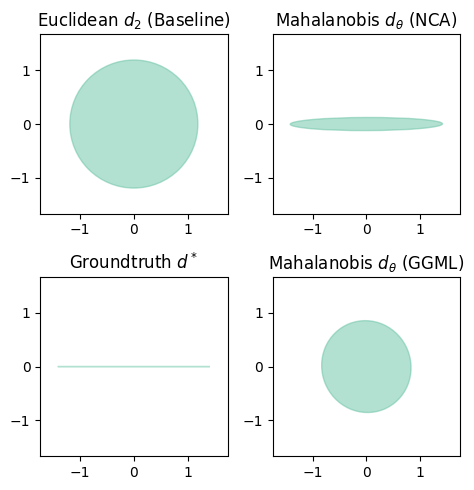

AttributeError: 'dict' object has no attribute 'compute_OT_on_dists'

<Figure size 240x240 with 0 Axes>

In [ ]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True,precision=16)
np.save("/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/w_theta.npy",w_theta.clone().detach().numpy())
print(w_theta.clone().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3,6))


#fig, ax = plt.subplots(figsize=(3,3))
ax = plot_w_theta(np.identity(2), ax=axs[0,0])
print(ax)
ax.set_title(r'Euclidean $d_2$ (Baseline)')
ax.get_figure().set_size_inches(4.8,5)

ax = plot_w_theta(w_theta.clone().detach().numpy(), ax=axs[1,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (GGML)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(M=np.asarray([[9.85031407, 0.02607956],
       [0.02607956, 0.07327278]]), ax=axs[0,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (NCA)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(np.asarray([[1,0],[0,0]]), ax=axs[1,0])
print(ax)
ax.set_title(r'Groundtruth $d^*$')
#ax.get_figure().set_size_inches(2.4,5)

plt.tight_layout()
plt.show()
from matplotlib.pyplot import figure

figure(figsize=(3, 3), dpi=80)

training_data.compute_OT_on_dists(w = w_theta.clone().detach().numpy(),legend=None)


[  0.                  2.16                4.32
   6.48                8.64               10.8
  12.96               15.120000000000001  17.28
  19.44               21.6                23.76
  25.92               28.080000000000002  30.240000000000002
  32.400000000000006  34.56               36.72
  38.88               41.040000000000006  43.2
  45.36               47.52               49.68000000000001
  51.84               54.                 56.160000000000004
  58.32000000000001   60.480000000000004  62.64
  64.80000000000001   66.96000000000001   69.12
  71.28               73.44               75.60000000000001
  77.76               79.92               82.08000000000001
  84.24000000000001   86.4                88.56
  90.72               92.88000000000001   95.04
  97.2                99.36000000000001  101.52000000000001
 103.68              105.84              108.
 110.16000000000001  112.32000000000001  114.48
 116.64000000000001  118.80000000000001  120.96000000000001
 123.1

ValueError: x and y must have same first dimension, but have shapes (100,) and (18,)

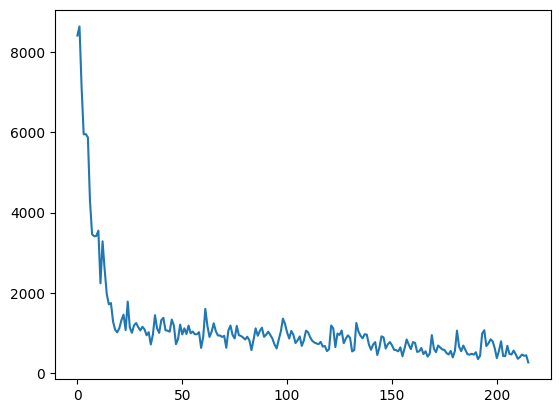

: 

: 

: 

In [ ]:
t = np.arange(len(losses))
datapoints_per_iteration = len(losses)/iterations
t2 = np.arange(0,len(losses),datapoints_per_iteration)
print(t2)
print(len(iteration_losses_total))
print(w_theta)
#fig, ax = plt.subplots()
plt.plot(t, losses, label = "loss minibatches")
plt.plot(t2, [l/datapoints_per_iteration for l in iteration_losses_total], label = "average loss iteration")
plt.legend() 




#print(total_loss_best_theta)


In [ ]:
for p1 in 

SyntaxError: invalid syntax (2993858587.py, line 1)

: 

: 

: 